In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

First, we're going to import data on the median income by county.

This data is contained in the file est18.all.xls, an Excel file. (If you're able to) open this file to see what the format looks like.

Luckily for us, _pandas_ has a _read_excel_ function we can use here. First, let's check the documentation.

In [47]:
# pd.read_excel?

Out of all of the arguments, we are going to use four:
* `io` - This will be the filepath to our Excel file
* `sheet_name` - We'll specify the name of the sheet containing the data we need.
* `header` - The row containing the column names. Note that we start counting from 0.
* `usecols` - A string indicating the columns we want to include. We'll get the state, county, and median household income information.

In [48]:
median_income = pd.read_excel('../data/est18all.xls',
              sheet_name = 'est18ALL',
             header = 3,
             usecols = 'C,D,W')

In [49]:
median_income.head(2)

,Postal Code,Name,Median Household Income
0,US,United States,61937
1,AL,Alabama,49881


For this map, we only need the counties located in Tennessee.

In [50]:
median_income = median_income.loc[median_income['Postal Code'] == 'TN']
median_income.head(2)

,Postal Code,Name,Median Household Income
2471,TN,Tennessee,52366
2472,TN,Anderson County,50672


We can remove the first row.

In [51]:
median_income = median_income.iloc[1:]
median_income.head(2)

,Postal Code,Name,Median Household Income
2472,TN,Anderson County,50672
2473,TN,Bedford County,49860


Now, let's read in our counties shapefiles. This one was obtained from http://www.tngis.org/administrative-boundaries.htm

This creates a geopandas DataFrame, which is like a pandas DataFrame, but has geometry associated with it.

In [52]:
counties = gpd.read_file('../data/county/tncounty.shp')

In [53]:
counties.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


The `geometry` column contains shapely Polygon or Multipolygon objects giving the boundaries of each county.

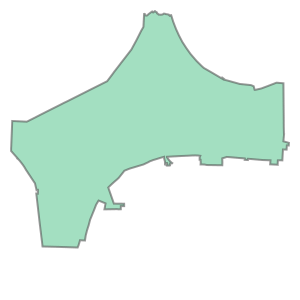

In [54]:
counties.loc[0, 'geometry']

In [55]:
# print(counties.loc[0,'geometry'])

If we call `.plot()` and a GeoDataFrame, it will render a plot using the geometry column.

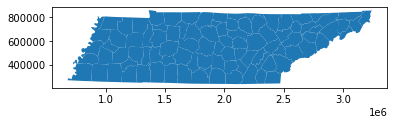

In [56]:
counties.plot();

If we want a larger plot, we can use `plt.subplots()` and set a figsize. When we create our plot, we need to specify that we want it to render on the axes we just created.

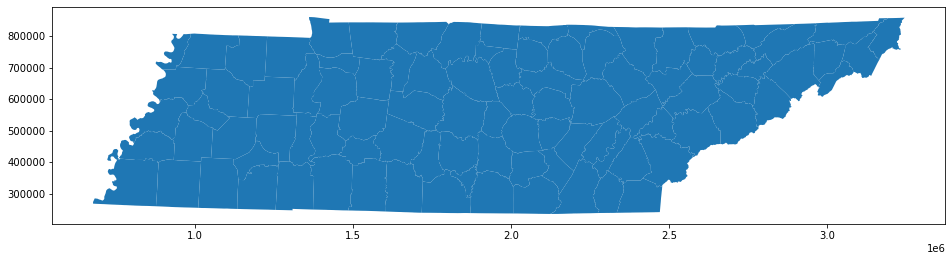

In [57]:
fig, ax = plt.subplots(figsize=(16,4))
counties.plot(ax = ax);

Since the axes are not conveying useful information, we can remove them.

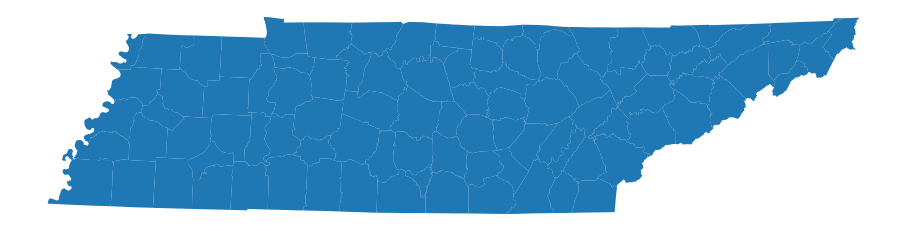

In [58]:
fig, ax = plt.subplots(figsize=(16,4))
counties.plot(ax = ax)
ax.axis('off');

Now, we can merge the geoDataFrame with our median income dataframe.

In [59]:
counties.head(2)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."


In [60]:
median_income.head(2)

,Postal Code,Name,Median Household Income
2472,TN,Anderson County,50672
2473,TN,Bedford County,49860


Some string manipulation so that the county name formats match.

In [61]:
median_income['NAME'] = median_income['Name'].str[:-7]

In [62]:
counties = pd.merge(left = counties,
                    right = median_income[['NAME', 'Median Household Income']])
counties.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Median Household Income
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",47508
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ...",38879
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774....",60874
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",57196
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",46565


To color our map based on a column, we can use the `column` argument.

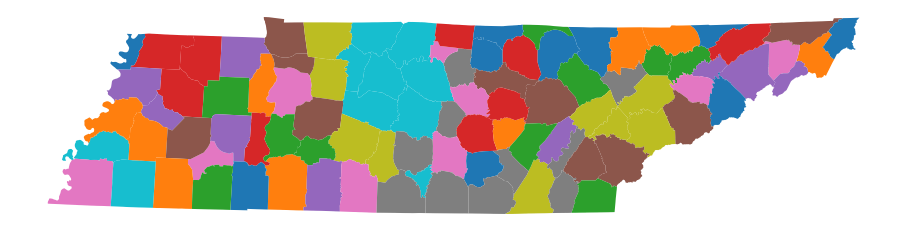

In [63]:
fig, ax = plt.subplots(figsize=(16,4))
counties.plot(column = 'Median Household Income',
              ax = ax)
ax.axis('off');

Why does our map look like this?

In [64]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   OBJECTID                 95 non-null     int64   
 1   NAME                     95 non-null     object  
 2   KEY                      95 non-null     object  
 3   SHAPE_AREA               95 non-null     float64 
 4   SHAPE_LEN                95 non-null     float64 
 5   geometry                 95 non-null     geometry
 6   Median Household Income  95 non-null     object  
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 5.9+ KB


It turns out that _pandas_ is treating the median income column as an object. We need to to realize that it is a numeric column."

In [65]:
counties['Median Household Income'] = pd.to_numeric(counties['Median Household Income'])

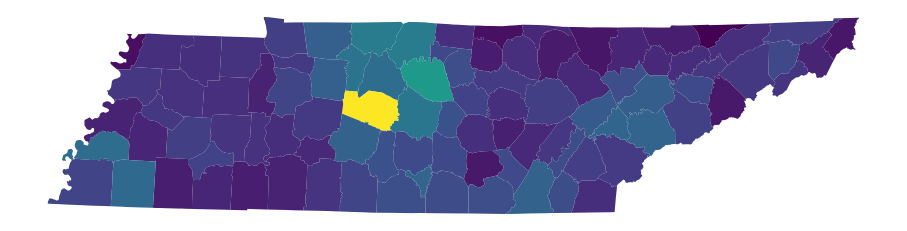

In [66]:
fig, ax = plt.subplots(figsize=(16,4))
counties.plot(column = 'Median Household Income',
              ax = ax)
ax.axis('off');

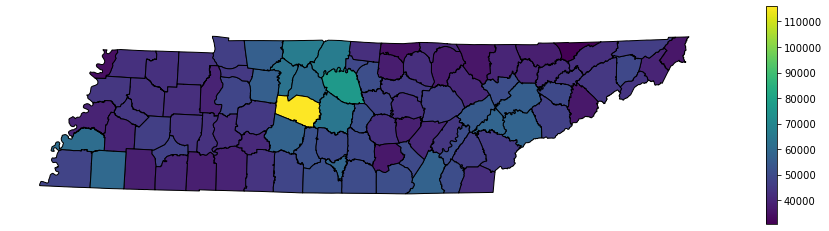

In [67]:
fig, ax = plt.subplots(figsize=(16,4))
counties.plot(column = 'Median Household Income', 
              edgecolor = 'black', 
              legend = True,
              ax = ax)
ax.axis('off');

By default, geopandas will use a continuous colorscale for the choropleth, which lead to a less than optimal map when you have a disproportionately large value, like we have with Williamson County. 

We can specify a different scheme to use. For example, let's use the [Jenks natural breaks classification method](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization).

We'll also specify a different colormap using the `cmap` argument. A list of named colormaps is available at https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html.

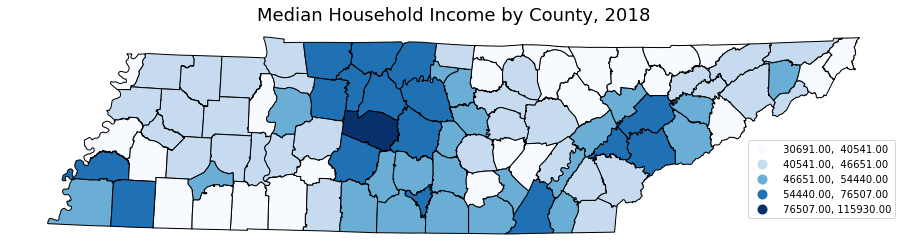

In [68]:
fig, ax = plt.subplots(figsize=(16,4))

counties.plot(column = 'Median Household Income', 
              edgecolor = 'black', 
              legend = True,
              cmap = 'Blues',
              scheme="NaturalBreaks",
              ax = ax)

# Position the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))

# Add a title
plt.title('Median Household Income by County, 2018', fontsize = 18)

ax.axis('off');

**Warning: More advanced code below**

The default legend formatting could be improved. The following cells shows how we can do some advanced formatting to change the legend labels.

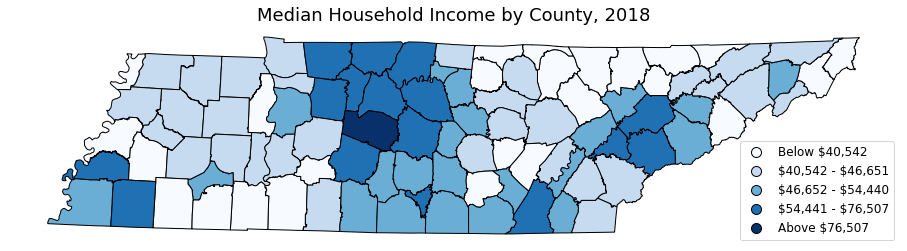

In [24]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(16,4))

counties.plot(column = 'Median Household Income', 
              edgecolor = 'black',
              legend = True,
              cmap = 'Blues',
              scheme="NaturalBreaks",
              ax = ax)

leg = ax.get_legend()

# Adjust the formatting of the legend
labels = []
n = len(leg.get_texts())
for i, lbl in enumerate(leg.get_texts()):
    label_text = lbl.get_text()
    lower = float(label_text.split()[0][:-1])
    upper = float(label_text.split()[1][:-1])
    if i == 0:
        new_text = "Below " + "\${:,.0f}".format(upper + 1)
    elif i == n - 1:
        new_text = "Above " + "\${:,.0f}".format(lower)
    else:
        new_text = "\${:,.0f}".format(lower + 1) + " - " + "\${:,.0f}".format(upper)
        
    labels.append(new_text)

# Adjust the marker appearance
# Extract the old markers and then modify by setting the edgecolor and edgewidth
markers = []
for line in leg.get_lines():
    marker = Line2D([0],[0], marker = 'o', 
                    markersize = line.get_markersize(), 
                    color = line.get_markerfacecolor(),
                    linestyle = 'None',
                    markeredgecolor = 'black',
                    markeredgewidth = 1)
    markers.append(marker)

# Redraw the legend with the new labels and markers
plt.legend(markers, labels, fontsize = 12)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))
    
plt.title('Median Household Income by County, 2018', fontsize = 18)

ax.axis('off');

----
## Week four coding tasks

 ### 1. Create a choropleth showing the unemployment rate per county for each Tennessee county.

In [69]:
unemployment = pd.read_csv('../data/tn_unemployment.csv')

In [70]:
unemployment['Name'] = unemployment['Name'].str.split(' County, TN', expand=True)[0]

In [71]:
counties

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Median Household Income
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",47508
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ...",38879
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774....",60874
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",57196
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",46565
...,...,...,...,...,...,...,...
90,91,McNairy,47109,1.563586e+10,566369.132062,"POLYGON ((1137985.762 344601.643, 1139350.519 ...",39859
91,92,Franklin,47051,1.605093e+10,621176.096919,"POLYGON ((1873015.265 239618.144, 1872957.848 ...",50201
92,93,Bradley,47011,9.241234e+09,457372.233476,"POLYGON ((2274954.438 239788.911, 2275552.803 ...",50427
93,94,Marion,47115,1.428734e+10,529431.591556,"POLYGON ((2126056.390 236919.771, 2122873.509 ...",50819


Add unemployment rates to counties geopandas df below (geopandas MUST be left!)

In [72]:
counties = pd.merge(right=unemployment[['Name', 'unemployment_rate']], right_on = 'Name',
         left = counties, left_on= 'NAME').drop('NAME', axis = 1)

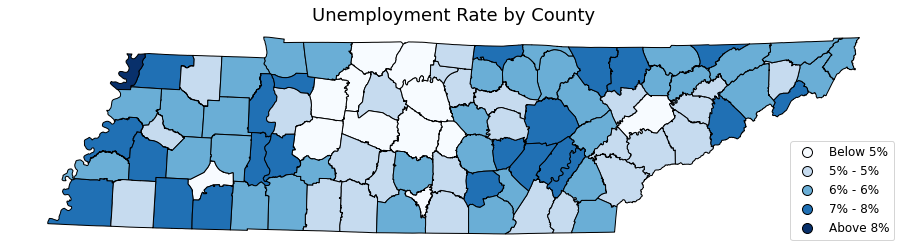

In [78]:
fig, ax = plt.subplots(figsize=(16,4))

counties.plot(column = 'unemployment_rate', 
              edgecolor = 'black', 
              legend = True,
              cmap = 'Blues',
              scheme="NaturalBreaks",
              ax = ax)

leg = ax.get_legend()

# Adjust the formatting of the legend
labels = []
n = len(leg.get_texts())
for i, lbl in enumerate(leg.get_texts()):
    label_text = lbl.get_text()
    lower = float(label_text.split()[0][:-1])
    upper = float(label_text.split()[1][:-1])
    if i == 0:
        new_text = "Below " + "{:,.0f}%".format(upper + 1)
    elif i == n - 1:
        new_text = "Above " + "{:,.0f}%".format(lower)
    else:
        new_text = "{:,.0f}%".format(lower + 1) + " - " + "{:,.0f}%".format(upper)
        
    labels.append(new_text)

# Adjust the marker appearance
# Extract the old markers and then modify by setting the edgecolor and edgewidth
markers = []
for line in leg.get_lines():
    marker = Line2D([0],[0], marker = 'o', 
                    markersize = line.get_markersize(), 
                    color = line.get_markerfacecolor(),
                    linestyle = 'None',
                    markeredgecolor = 'black',
                    markeredgewidth = 1)
    markers.append(marker)

# Redraw the legend with the new labels and markers
plt.legend(markers, labels, fontsize = 12)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))
    
plt.title('Unemployment Rate by County', fontsize = 18)

ax.axis('off');

### 2. Create a choropleth showing the SHADAC category for each county (adequate, low inadequate, and moderately inadequate).

In [79]:
physicians = pd.read_csv('../data/primary_care_physicians.csv')

In [80]:
population = pd.read_csv('../data/population_by_county.csv')


In [81]:
physicians = pd.merge(left = physicians, right = population[['FIPS','population','urban']], left_on='FIPS', right_on = 'FIPS')

In [82]:
physicians.loc[physicians.population/physicians.primary_care_physicians < 1500,'supply'] = 'adequate'
physicians.loc[(physicians.population/physicians.primary_care_physicians > 1500) &
               (physicians.population/physicians.primary_care_physicians < 3500),'supply'] = 'moderately adequate'
physicians.loc[physicians.population/physicians.primary_care_physicians > 3500,'supply'] = 'inadequate'

In [84]:
tn_physicians = physicians.loc[physicians.state == 'Tennessee']

,FIPS,state,county,primary_care_physicians,population,urban,supply
2394,47001,Tennessee,Anderson,39.0,76061,Urban,moderately adequate
2395,47003,Tennessee,Bedford,15.0,48292,Rural,moderately adequate
2396,47005,Tennessee,Benton,3.0,16140,Rural,inadequate
2397,47007,Tennessee,Bledsoe,1.0,14836,Rural,inadequate
2398,47009,Tennessee,Blount,90.0,129927,Urban,adequate
...,...,...,...,...,...,...,...
2484,47181,Tennessee,Wayne,5.0,16693,Rural,moderately adequate
2485,47183,Tennessee,Weakley,18.0,33510,Rural,moderately adequate
2486,47185,Tennessee,White,9.0,26800,Rural,moderately adequate
2487,47187,Tennessee,Williamson,338.0,225389,Urban,adequate


In [88]:
counties = pd.merge(left = counties, left_on= 'Name',
                    right=tn_physicians[['county', 'supply']], right_on = 'county',
                     ).drop('county', axis = 1)

In [89]:
counties

,OBJECTID,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Median Household Income,Name,unemployment_rate,supply
0,76,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",47508,Chester,4.3,inadequate
1,77,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ...",38879,Wayne,5.3,moderately adequate
2,78,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774....",60874,Tipton,5.2,inadequate
3,79,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",57196,Hamilton,4.8,adequate
4,80,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",46565,Stewart,5.6,inadequate
...,...,...,...,...,...,...,...,...,...
90,91,47109,1.563586e+10,566369.132062,"POLYGON ((1137985.762 344601.643, 1139350.519 ...",39859,McNairy,7.3,moderately adequate
91,92,47051,1.605093e+10,621176.096919,"POLYGON ((1873015.265 239618.144, 1872957.848 ...",50201,Franklin,4.7,moderately adequate
92,93,47011,9.241234e+09,457372.233476,"POLYGON ((2274954.438 239788.911, 2275552.803 ...",50427,Bradley,5.1,moderately adequate
93,94,47115,1.428734e+10,529431.591556,"POLYGON ((2126056.390 236919.771, 2122873.509 ...",50819,Marion,5.5,moderately adequate


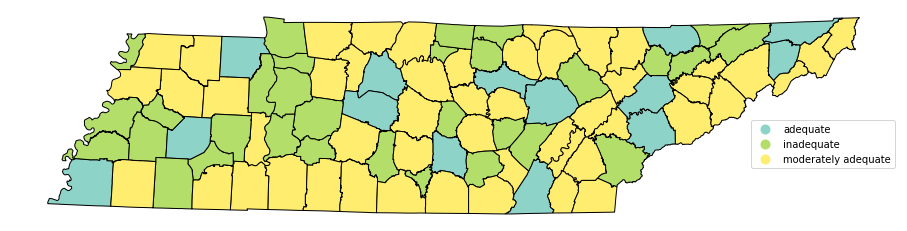

In [96]:
fig, ax = plt.subplots(figsize=(16,4))

counties.plot(column = 'supply', 
              edgecolor = 'black', 
              legend = True,
              cmap = 'Set3',
              ax = ax)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5))
ax.axis('off');